In [1]:
import torch 
from torch import optim
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from datasets import COCOADatasetGraph

from Trainer import MaskTrainer
from UNet import UNet

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Data

In [3]:
def COCOADataset(phase, transform=None):
    root_dict = {'train': "../data/COCOA/train2014", 'val': "../data/COCOA/val2014"}
    img_root = root_dict[phase]
    annot_path = "../data/COCOA/annotations/COCO_amodal_{}2014.json".format(phase)
    graph_root = "../data/COCOA/pixel_graphs_{}/".format(phase)
    return COCOADatasetGraph(annot_path, img_root, graph_root, transform=transform)

# Training

In [4]:
model = UNet()
model = model.to(device)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(128)
])

train_dataset = COCOADataset('train', transform=transform)
val_dataset = COCOADataset('val', transform=transform)

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
trainer = MaskTrainer(device, model, train_dataset, val_dataset, 32, optimizer, scheduler=scheduler, 
                      loss=nn.MSELoss(), num_workers=2, exp_name='unet')

In [ ]:
train_log = trainer.train(10, checkpoint=False)

  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 0/9 --
Training Loss: 0.02736938355749921
Validation Loss: 0.016720417532182875
Time since start: 48.275492906570435


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 1/9 --
Training Loss: 0.016554302535951138
Validation Loss: 0.01668410360192259
Time since start: 96.35491347312927


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 2/9 --
Training Loss: 0.016382372372229642
Validation Loss: 0.016672658046618813
Time since start: 145.13524770736694


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 3/9 --
Training Loss: 0.01603990749609244
Validation Loss: 0.016659099276044538
Time since start: 193.41279816627502


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 4/9 --
Training Loss: 0.01674989750019357
Validation Loss: 0.01666300989953535
Time since start: 242.42303133010864


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 5/9 --
Training Loss: 0.016626945626037785
Validation Loss: 0.016652146154748543
Time since start: 291.1939170360565


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 6/9 --
Training Loss: 0.016299077698701543
Validation Loss: 0.016669398062818107
Time since start: 341.41656255722046


 55%|█████▍    | 23/42 [00:10<00:08,  2.36it/s]

# Results

In [15]:
def plot_predictions(img, graph_pred):
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(graph_pred.transpose(1, 2, 0)[:, :, 0])
    plt.title("Graph 0")
    plt.subplot(1, 3, 3)
    plt.imshow(graph_pred.transpose(1, 2, 0)[:, :, 1])
    plt.title("Graph 1")
    plt.show()

In [16]:
batch = next(iter(trainer.val_loader))
img, _, _ = batch
graph_pred = trainer.evaluate(batch)

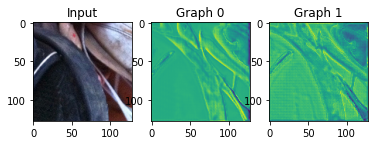

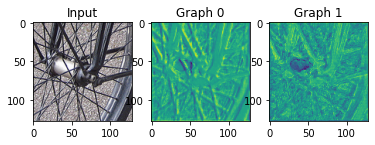

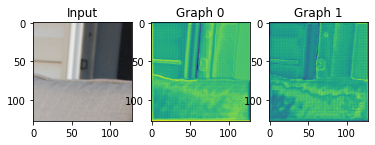

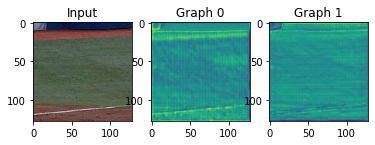

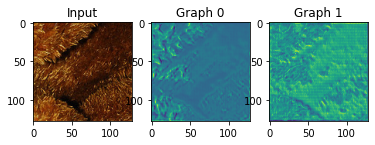

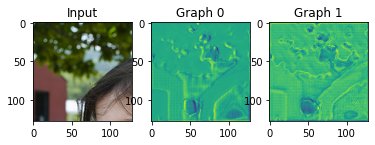

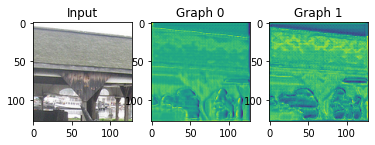

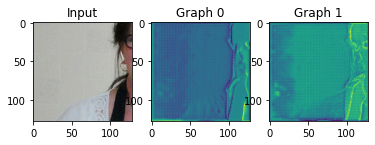

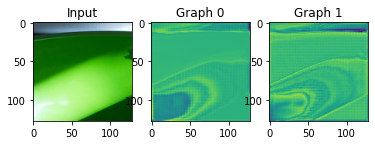

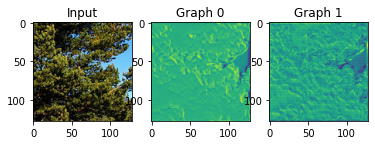

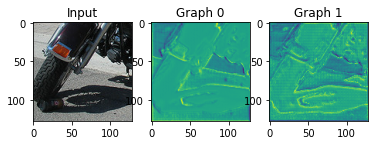

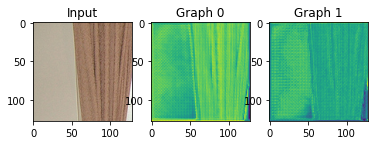

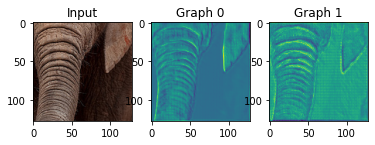

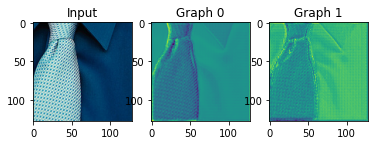

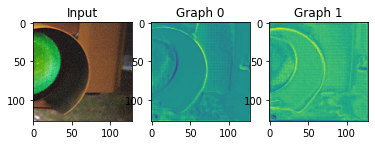

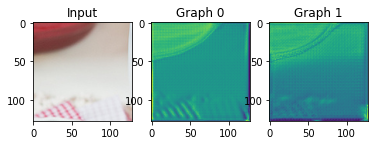

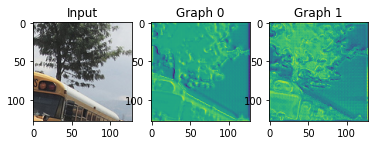

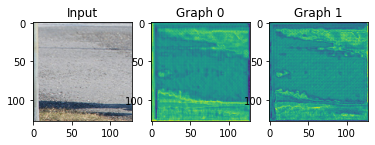

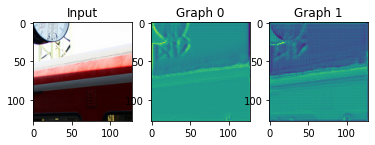

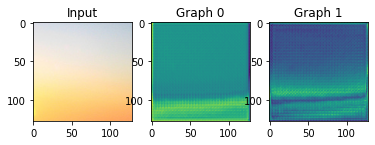

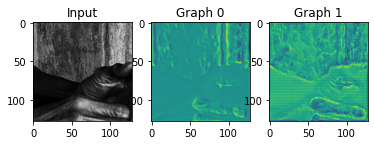

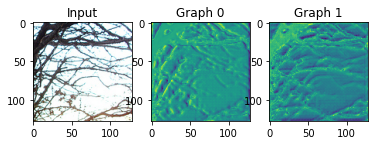

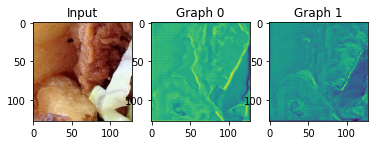

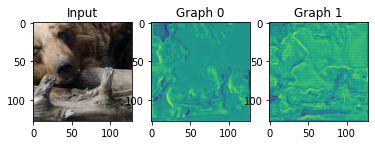

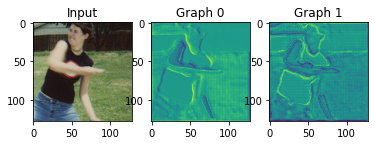

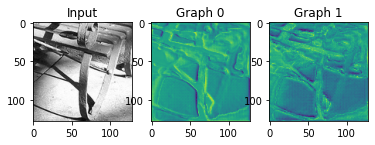

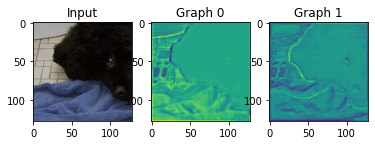

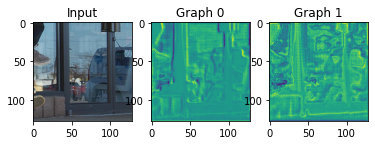

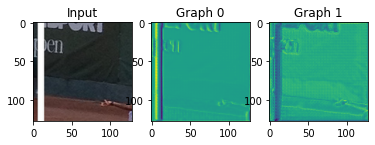

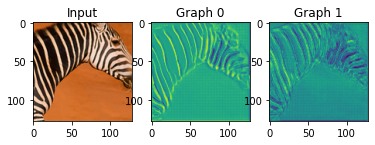

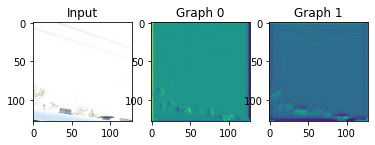

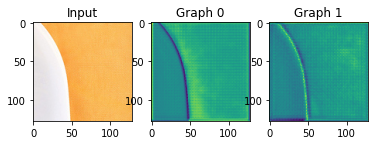

In [17]:
for i in range(len(img)):
    plot_predictions(img[i], graph_pred[i])